In [10]:
import TurbPy as tb
from TurbPy.imports import *

In [11]:
# deck = 'KH_Lv1di/'
# deck = 'turb2/'
# deck = 'turb_vth0.01/'
# deck = 'KH_test/'
# deck = 'KH_beta0.1/'
# deck = 'KH_subash/'
# deck = 'KH_new/'
# deck = 'KH_800ppc/'
deck =  'KH_200ppc_200wci/'

dirs = '/pscratch/sd/g/goodwill/' + deck

figs = '/pscratch/sd/g/goodwill/Fig/' + deck

info = tb.get_vpic_info(dirs)
times = tb.get_times(dirs)
en_out = tb.read_energies(dirs)/(info['Lx/de'] * info['Ly/de'] * info['Lz/de'])

twci_out = np.linspace(0, times[-1] * info['dt*wci'], len(en_out['EM']))
twci = np.linspace(0, times[-1] * info['dt*wci'], len(times))

twce_out = np.linspace(0, times[-1] * info['dt*wce'], len(en_out['EM']))
twce = np.linspace(0, times[-1] * info['dt*wce'], len(times))

In [12]:
from TurbPy.load_vars import *
from TurbPy.vpic_info import *

def en_calc(dirs, filt = True, save = True):
  vpic_info = get_vpic_info(dirs)
  times = get_times(dirs)
  en = {}
  
  E_fe = np.zeros(len(times))
  E_the = np.zeros(len(times))
  E_fi = np.zeros(len(times))
  E_thi = np.zeros(len(times))
  E_m = np.zeros(len(times))
  E_e = np.zeros(len(times))

  for t in np.arange(len(times)):
    dx = vpic_info['dx/de']
    dy = vpic_info['dy/de']
    dz = vpic_info['dz/de']
    if filt == True:
      el = load_hydro_fil(dirs, times[t], 'electron')
      ion = load_hydro_fil(dirs, times[t], 'ion')
      f = load_field_fil(dirs, times[t])
    if filt == False:
      el = load_hydro(dirs, times[t], 'electron')
      ion = load_hydro(dirs,times[t], 'ion')
      f = load_fields(dirs, times[t])
    E_m[t] = (1/2) * np.sum(f['cbx']**2 + f['cby']**2 + f['cbz']**2) * dx * dy *dz
    E_e[t] = (1/2) * np.sum(f['ex']**2 + f['ey']**2 + f['ez']**2) * dx * dy * dz

    particle_mass = int(vpic_info['mi/me'])

    ux=ion['jx']/ion['rho']
    uy=ion['jy']/ion['rho']
    uz=ion['jz']/ion['rho']

    pxx = np.array(ion['txx'] - (ux)*ion['px'])
    pyy = np.array(ion['tyy'] - (uy)*ion['py'])
    pzz = np.array(ion['tzz'] - (uz)*ion['pz'])
    


    E_thi[t] = (1/2) * np.sum(pxx + pyy + pzz) * dx * dy * dz
    E_fi[t]  = (1/2) * particle_mass  * np.sum( np.abs(ion['rho']) * (ux**2 + uy**2 + uz**2)) * dx * dy * dz
    
    ux=el['jx']/el['rho']
    uy=el['jy']/el['rho']
    uz=el['jz']/el['rho']

    pxx = np.array(el['txx'] - (ux)*el['px'])
    pyy = np.array(el['tyy'] - (uy)*el['py'])
    pzz = np.array(el['tzz'] - (uz)*el['pz'])

    E_the[t] = (1/2) * np.sum(pxx + pyy + pzz) * dx * dy * dz
    E_fe[t]  = (1/2) * particle_mass  * np.sum( np.abs(el['rho']) * (ux**2 + uy**2 + uz**2)) * dx * dy * dz

  en['EM'] = E_m
  en['EE'] = E_e
  en['Ethi'] = E_thi
  en['Efi'] = E_fi
  en['Ethe'] = E_the
  en['Efe'] = E_fe
  en['Et'] = E_m + E_e + E_thi + E_fi + E_the + E_fe
  if save == True:
    pd.DataFrame(en).to_csv(dirs + 'en_calc.csv', sep = ',')
  return pd.DataFrame(en)

In [13]:
en = en_calc(dirs)/(info['Lx/de'] * info['Ly/de'] * info['Lz/de'])
# en = tb.read_calc_energies(dirs)/(info['Lx/de'] * info['Ly/de'] * info['Lz/de'])

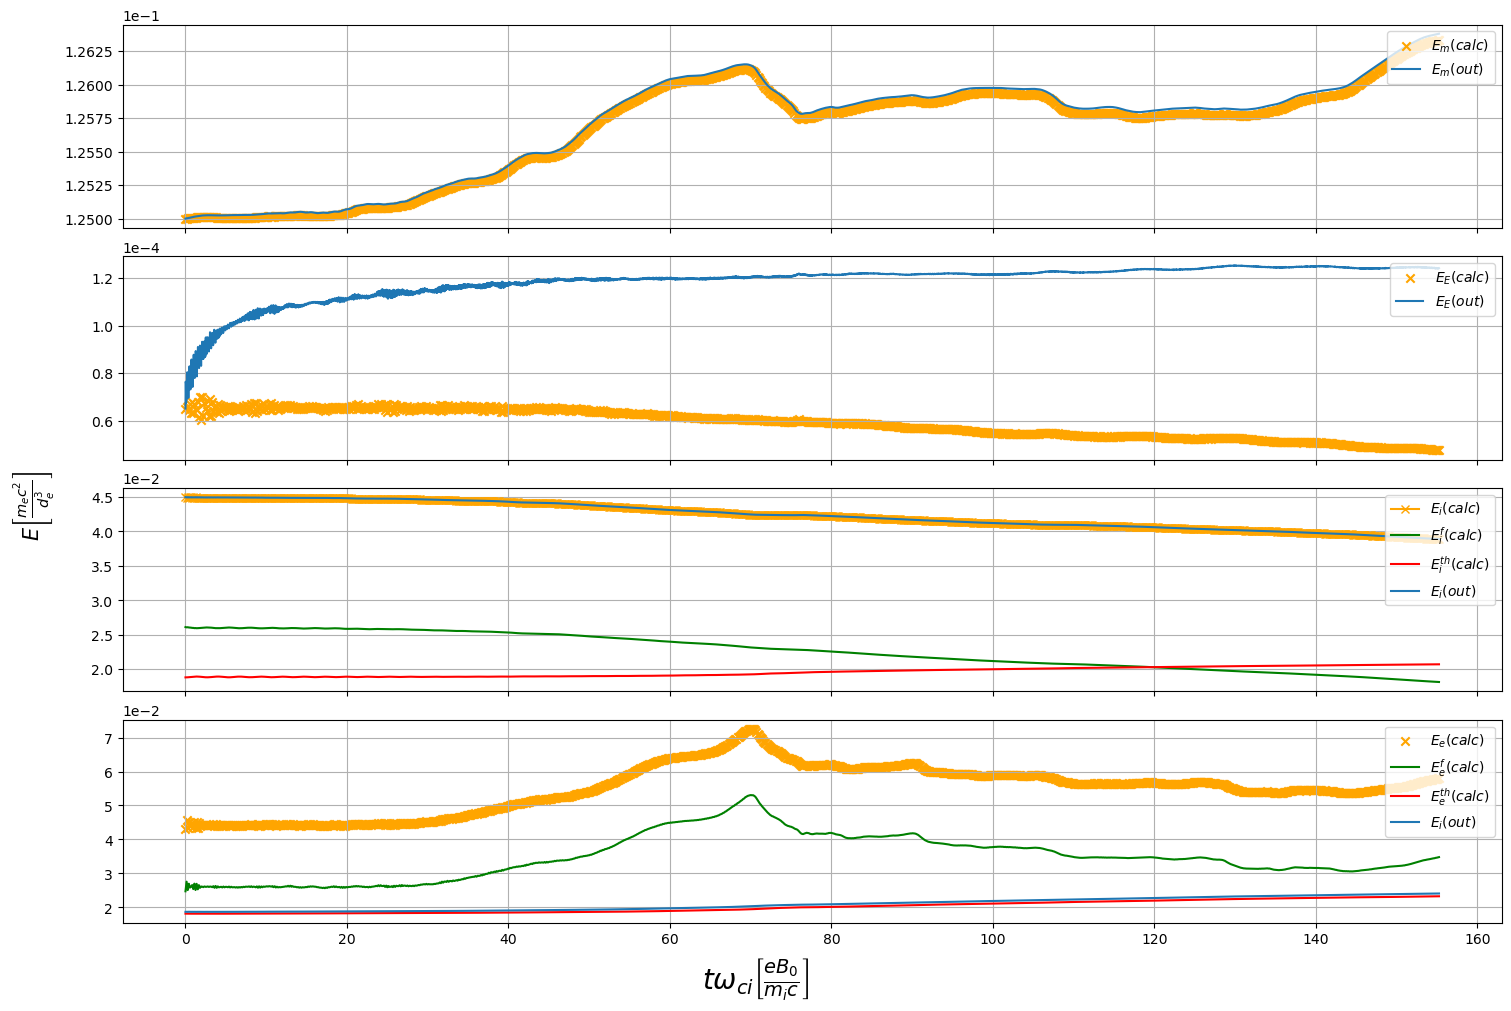

In [18]:
fig, axs = plt.subplots(4,1, figsize=(15, 10), sharex = True, layout='constrained')
axs[0].scatter(twci, en['EM'], color = 'orange', marker = 'x', label = r'$E_m (calc)$')
axs[0].plot(twci_out, en_out['EM'] , label = r'$E_m (out)$')

axs[1].scatter(twci, en['EE'], color = 'orange', marker = 'x', label = r'$E_E (calc)$')
axs[1].plot(twci_out, en_out['EE'], label = r'$E_E (out)$')

axs[2].plot(twci, en['Ethi'] + en['Efi'], color = 'orange', marker = 'x' , label = r'$E_i (calc)$')
axs[2].plot(twci, en['Efi'], color = 'green' , label = r'$E^{f}_i (calc)$')
axs[2].plot(twci, en['Ethi'], color = 'red' , label = r'$E^{th}_i (calc)$')
axs[2].plot(twci_out, en_out['Ei'],label = r'$E_i (out)$')

axs[3].scatter(twci, (en['Ethe'] + en['Efe']), color = 'orange', marker = 'x', label = r'$E_e (calc)$')
axs[3].plot(twci, en['Efe'], color = 'green', label = r'$E^{f}_e (calc)$')
axs[3].plot(twci, en['Ethe'], color = 'red' , label = r'$E^{th}_e (calc)$')
axs[3].plot(twci_out, en_out['Ee'],label = r'$E_i (out)$')


axs[0].legend(loc = 'upper right')
axs[1].legend(loc = 'upper right')
axs[2].legend(loc = 'upper right')
axs[3].legend(loc = 'upper right')

axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[3].grid()

axs[0].ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
axs[1].ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
axs[2].ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
axs[3].ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))

fig.supylabel(r'$E \left[ \frac{m_e c^2}{d_e^3} \right] $', size = 15)
fig.supxlabel(r'$ t \omega_{ci} \left[ \frac{e B_0}{m_i c} \right]$', size = 20)

plt.savefig(figs + 'en_comp_calc.jpg', dpi = 400)

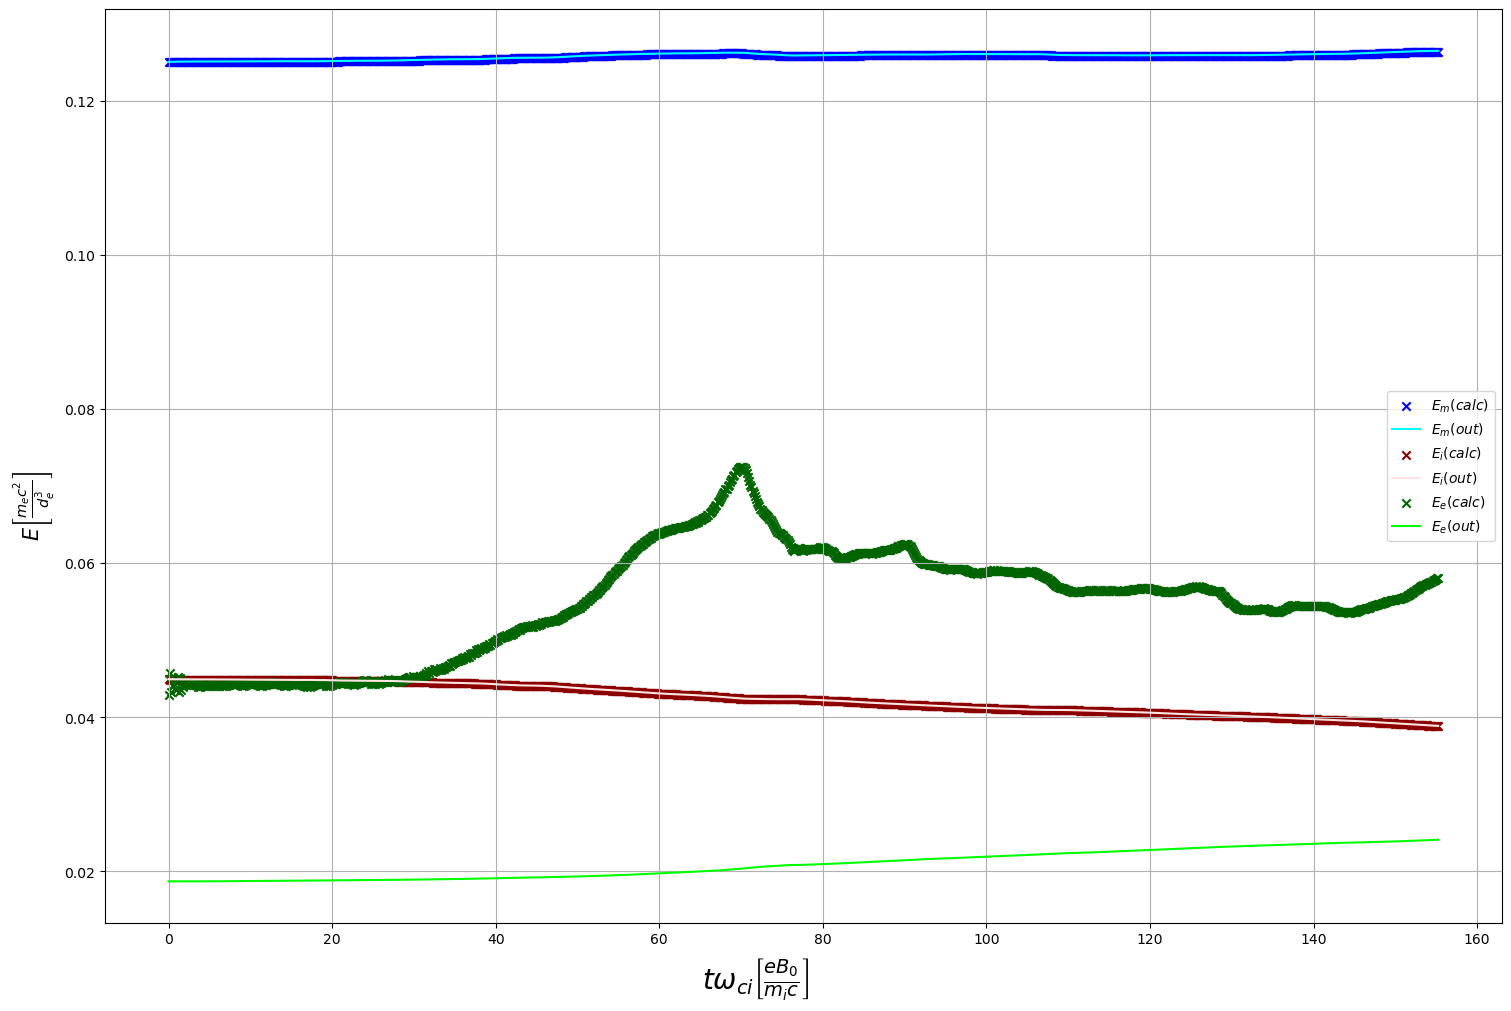

In [16]:
fig, axs = plt.subplots(1,1, figsize=(15, 10), sharex = True, layout='constrained')
axs.scatter(twci, en['EM'] + en['EE'], color = 'blue', marker = 'x', label = r'$E_m (calc)$')
axs.plot(twci_out, en_out['EM'] + en_out['EE'] , color = 'aqua', label = r'$E_m (out)$')

axs.scatter(twci, en['Ethi'] + en['Efi'], color = 'darkred', marker = 'x' , label = r'$E_i (calc)$')
# axs.plot(twci, en['Efi'], color = 'fuchsia' , label = r'$E^{f}_i (calc)$')
# axs.plot(twci, en['Ethi'], color = 'indigo' , label = r'$E^{th}_i (calc)$')
axs.plot(twci_out, en_out['Ei'], color = 'mistyrose',label = r'$E_i (out)$')

axs.scatter(twci, (en['Ethe'] + en['Efe']), color = 'darkgreen', marker = 'x', label = r'$E_e (calc)$')
# axs.plot(twci, en['Efe'], color = 'orange', label = r'$E^{f}_e (calc)$')
# axs.plot(twci, en['Ethe'], color = 'darkorange' , label = r'$E^{th}_e (calc)$')
axs.plot(twci_out, en_out['Ee'], color = 'lime', label = r'$E_e (out)$')

# axs.set_yscale('log')
axs.legend()

axs.grid(which = 'both')


# axs.ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))


fig.supylabel(r'$E \left[ \frac{m_e c^2}{d_e^3} \right] $', size = 15)
fig.supxlabel(r'$ t \omega_{ci} \left[ \frac{e B_0}{m_i c} \right]$', size = 20)

plt.savefig(figs + 'enout_calc.jpg', dpi = 400)